In [1]:
import argparse
import json
import os
import pprint
import sys
from pathlib import Path

import cv2
import h5py
# import hydra
import numpy as np
import torch
import torchvision
import yaml
from easydict import EasyDict
# from hydra.experimental import compose, initialize
# from omegaconf import DictConfig, OmegaConf
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

from deoxys import config_root
# Control import
from deoxys.franka_interface import FrankaInterface
# from deoxys.utils import RobotStateRawObsDictGenerator, YamlConfig
from deoxys.utils import  YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.input_utils import input2action
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger
from deoxys.experimental.motion_utils import follow_joint_traj, reset_joints_to


import argparse
import json
import numpy as np
import time
import os
import shutil
import psutil
import sys
import socket
import traceback

from threading import Thread
import time

from collections import OrderedDict

import torch
from torch.utils.data import DataLoader

import robomimic
import robomimic.utils.train_utils as TrainUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils
from robomimic.config import config_factory
from robomimic.algo import algo_factory, RolloutPolicy
from robomimic.utils.log_utils import PrintLogger, DataLogger, flush_warnings


import robomimic.utils.train_utils as TrainUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.tensor_utils as TensorUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils

import imageio 

import matplotlib.pyplot as plt

from robomimic.envs.wrappers import EnvWrapper
from copy import deepcopy
import textwrap
import numpy as np
from collections import deque

from camera_utils import MyRealSense, CVCamera

np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()

pybullet build time: Nov 28 2023 23:45:17
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/franka_deoxys/robomimic/robomimic/scripts/setup_macros.py
)


/home/franka_deoxys/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
device = TorchUtils.get_torch_device(try_to_use_cuda=True)
device 

device(type='cuda', index=0)

In [3]:
class BaseRawObsDictGenerator:
    def __init__(self, *args, **kwargs):
        self.last_obs_dict = None

    def get_raw_obs_dict(self, state_info):
        """
        Args:
           state_info (dict): A dictionary of robot state + images
        """
        obs_dict = {}
        raise NotImplementedError

    def load(self):
        raise NotImplementedError


class RobotStateRawObsDictGenerator(BaseRawObsDictGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def load(self, obs_dict, key, value, check_valid=True):
        """
        This is to check if the data is correct or not. Sometimes the data will be all zero depending on the networking conditions.
        """
        if (
            (
                np.sum(np.abs(value)) == 0.0
                and key in ["ee_states", "joint_states", "gripper_states"]
            )
            and check_valid
            and self.last_obs_dict is not None
        ):
            value = self.last_obs_dict[key]
        obs_dict[key] = value

    def get_raw_obs_dict(self, state_info):
        last_state = state_info["last_state"]
        last_gripper_state = state_info["last_gripper_state"]
        obs_dict = {}

        ee_states = np.array(last_state.O_T_EE)
        joint_states = np.array(last_state.q)
        gripper_states = np.array([last_gripper_state.width])

        self.load(obs_dict, "ee_states", ee_states)
        self.load(obs_dict, "joint_states", joint_states)
        # Gripper widh will probably become zero
        self.load(obs_dict, "gripper_states", gripper_states, check_valid=False)

        for state in ["ee_states", "joint_states", "gripper_states"]:
            if (
                np.sum(np.abs(obs_dict[state])) <= 1e-6
                and self.last_obs_dict is not None
            ):
                print(f"{state} missing!!!!")
                obs_dict[state] = self.last_obs_dict[state]
        self.last_obs_dict = obs_dict
        return obs_dict

In [4]:
ckpt_path = "/home/franka_deoxys/data_franka/block_green_on_blue/policy_img/lstm/model_epoch_80.pth"   #not good

ckpt_path = "/home/franka_deoxys/data_franka/block_green_on_blue/policy_img/lstm/model_epoch_120.pth"   #not good

ckpt_path = "/home/franka_deoxys/data_franka/block_green_on_blue/policy_img/lstm/model_epoch_160.pth"   #not good


ckpt_path = "/home/franka_deoxys/data_franka/block_green_on_blue/policy_img/lstm/model_epoch_180.pth"   #not good


assert os.path.exists(ckpt_path)

 
# restore policy
policy, ckpt_dict = FileUtils.policy_from_checkpoint(ckpt_path=ckpt_path, device=device, verbose=False)
ckpt_dict = FileUtils.maybe_dict_from_checkpoint(ckpt_path=ckpt_path, ckpt_dict=None)
# algo name and config from model dict
algo_name, _ = FileUtils.algo_name_from_checkpoint(ckpt_dict=ckpt_dict)
config, _ = FileUtils.config_from_checkpoint(algo_name=algo_name, ckpt_dict=ckpt_dict, verbose=False)

config.unlock()
config.train.data="/home/franka_deoxys/data_franka/block_green_on_blue/franka_block_gonb_50.hdf5"
config.lock() 


ObsUtils.initialize_obs_utils_with_config(config)

shape_meta = FileUtils.get_shape_metadata_from_dataset(
    dataset_path=config.train.data,
    all_obs_keys=config.all_obs_keys,
    verbose=False
)
trainset, validset = TrainUtils.load_data_for_training(
    config, obs_keys=shape_meta["all_obs_keys"])
len(trainset.demos)

/home/franka_deoxys/robomimic/robomimic/utils/file_utils.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_dict = torch.load(ckpt_path)



============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['joint_states', 'ee_states', 'gripper_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb', 'agentview_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['joint_states', 'ee_states', 'gripper_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb', 'agentview_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 217.16it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 4536/4536 [00:02<00:00, 1728.20it/s]


50

In [5]:
model = policy.policy
model.set_eval()

In [6]:
# model 

In [7]:
logger.warn("This is a very dummy control policy!!!!!")

args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(
    os.path.join(config_root, args.controller_cfg)
).as_easydict()
controller_type = args.controller_type

spacemouse = SpaceMouse(vendor_id=9583, product_id=50734)
spacemouse.start_control()

raw_obs_dict_generator = RobotStateRawObsDictGenerator()

import time

time.sleep(0.3)
dummy_torch_model = torch.nn.Linear(7, 1)

[Deoxys Examples WARNING] This is a very dummy control policy!!!!! (Ln 1)
Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: SpaceMouse Wireless

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



/tmp/ipykernel_270563/2597759035.py:1: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("This is a very dummy control policy!!!!!")


In [8]:
args 

Namespace(interface_cfg='charmander.yml', folder=PosixPath('/home/franka_deoxys/.local/share/jupyter/runtime/kernel-v2-229765fsZYJ5bqnwMF.json'), controller_type='OSC_POSE', controller_cfg='osc-position-controller.yml')

In [9]:
file=trainset.hdf5_file
demo = file['data']['demo_5']
actions=demo['actions']
actions.shape

(92, 7)

In [10]:
# file["data"].attrs["config"]
for key in file["data"].attrs.keys():
    print(key, file["data"].attrs[key])

camera_ids [0 1]
num_demos 50
total 4536


In [11]:
joint_sequence = file["data/demo_1/obs/joint_states"]
joint_sequence.shape

(70, 7)

In [12]:
def set_gripper(open=True):
    d=-1. if open else 1.0
    action_close=np.array([ 0.,  0., -0.,  0.,  0., -0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

In [24]:
logger.info("Resetting to the initial configuration")
reset_joints_to(robot_interface, joint_sequence[0])
set_gripper(open=True)

[Deoxys Examples INFO] Resetting to the initial configuration (Ln 1)
JOINT_POSITION


In [14]:
# set_gripper(open=False)

In [18]:
cam_wrist=MyRealSense()
cam_front=CVCamera(8)

tb1=Thread(target=cam_wrist.run)
tb1.start()
tb2=Thread(target=cam_front.run)
tb2.start()


In [16]:
# cr_interfaces[camera_id].current_frame

In [19]:
def get_current_obs(robot_interface, cam_wrist, cam_front):
    last_state = robot_interface._state_buffer[-1]
    last_gripper_state = robot_interface._gripper_state_buffer[-1]

    obs_dict = raw_obs_dict_generator.get_raw_obs_dict(
    {"last_state": last_state, "last_gripper_state": last_gripper_state})

    # print(obs_dict) 

    img_wrist=cam_wrist.current_frame
    img_front=cam_front.current_frame

    agentview_rgb=cv2.resize(img_wrist, (120, 120))  
    eye_in_hand_rgb=cv2.resize(img_front, (120, 120)) 


    # agentview_rgb.shape, eye_in_hand_rgb.shape

    obs_dict['agentview_rgb']=agentview_rgb.transpose(2, 1, 0)
    obs_dict['eye_in_hand_rgb']=eye_in_hand_rgb.transpose(2, 1, 0)
    return obs_dict

In [20]:
model.set_eval()

In [21]:
obs_dict=get_current_obs(robot_interface, cam_wrist, cam_front)
for key in obs_dict.keys():
    # obs_dict[key]=obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (16,)
joint_states (7,)
gripper_states (1,)
agentview_rgb (3, 120, 120)
eye_in_hand_rgb (3, 120, 120)


In [22]:
ob2 = policy._prepare_observation(obs_dict)
ac = policy.policy.get_action(obs_dict=ob2, goal_dict=None)
ac=ac.detach().cpu().numpy()[0]
ac 

array([ 0.001, -0.215, -0.015,  0.006,  0.002,  0.001, -1.   ],
      dtype=float32)

In [23]:
for _ in range(500):
    action, grasp = input2action(
        device=spacemouse,
        controller_type=controller_type,
    )
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    obs_dict=get_current_obs(robot_interface, cam_wrist, cam_front)
    ob2 = policy._prepare_observation(obs_dict)
    ac = policy.policy.get_action(obs_dict=ob2, goal_dict=None)
    action=ac.detach().cpu().numpy()[0] 
    
    robot_interface.control(
        controller_type=controller_type,
        action=action,
        controller_cfg=controller_cfg,
    )
robot_interface.close()

KeyboardInterrupt: 

In [ ]:
action

In [ ]:
robot_interface.close()

In [22]:
import matplotlib.pyplot as plt

In [ ]:
# cam_wrist=MyRealSense()
# cam_front=CVCamera(8)

In [33]:
# img_wrist=cam_wrist.get_current_frame(scale=0.5)
# img_front=cam_front.get_current_frame(scale=0.5)

img_wrist=cam_wrist.current_frame
img_front=cam_front.current_frame

img_wrist.shape, img_front.shape

((360, 640, 3), (240, 320, 3))

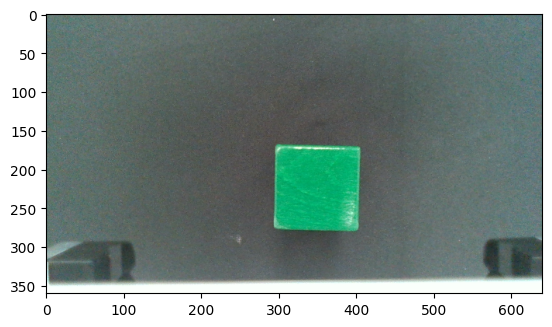

In [34]:
plt.imshow(img_wrist)

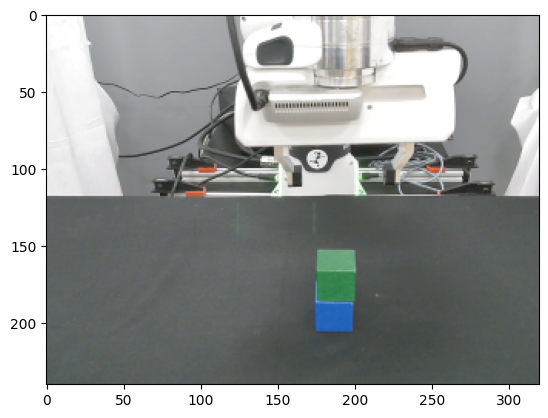

In [35]:
plt.imshow(img_front)